## Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import math
from sklearn.ensemble import IsolationForest
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
import datetime 

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_selected_final_24_4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BTC  Price Prediction/data_selected_final_24_4.csv')

## Functions

### Sliding Windows & splitting data

In [4]:
def sliding_intervals(df):
  
  # selecting intervals with window side of 500
  window = 500
  window_interval = []
  train_windows = []
  test_windows = []

  # splitting each window into train and test data sets
  test_window = int(window*0.2)
  train_window = int(window*0.8)
  for i in range(0, len(df), test_window):
    if len(df.iloc[i:i+train_window,:]) >=400:
      window_interval.append(df.iloc[i:i+window,:].reset_index(drop=True)) 
      train_windows.append(df.iloc[i:i+train_window,:].reset_index(drop=True))
      test_windows.append(df.iloc[i+train_window:i+window,:].reset_index(drop=True))
  return window_interval,train_windows, test_windows

### Feature Scaling

In [5]:
# function to scale data with robust and min-max scalers
def scale_data(X_fit,X_tras):
  scale1 = RobustScaler()
  scale2 = MinMaxScaler()
  scale = make_pipeline(scale1,scale2)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to scale data with standard scaler
def scale_data1(X_fit,X_tras):
  scale1 = StandardScaler()
  scale = make_pipeline(scale1)
  scale.fit(X_fit)
  return scale.transform(X_tras)

# function to decompose the data into components using PCA
def Principle_component_analysis(X_fit,X_tras,a):
  pca = PCA(n_components=a)  
  X_fit = pca.fit_transform(X_fit)
  X_tras = pca.transform(X_tras)
  return X_fit,X_tras


### Metrics

In [6]:
# Function to calculate Root Mean Square Error
# where y and y_pred are actual and predicted target variables
def RMSE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += math.pow((y[i]-y_pred[i]),2)
  MSE = sum/n
  RMSE = np.sqrt(MSE)
  return RMSE

In [7]:
# Function to calculate  Mean Absolute Error:
def MAE(y,y_pred):
  n =len(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAE = sum/n
  return MAE

In [8]:
# Function to calculate Mean Absolute Percentage Error:
def MAPE(y,y_pred):
  n =len(y)
  y_sum = np.sum(y)
  sum = 0
  for i in range(n):
    sum += abs(y[i]-y_pred[i])
  MAPE = (sum/y_sum)
  return MAPE

In [9]:
def metrics_final(data,y,y_pred):
  print('MAE_'+str(data)+':',MAE(y,y_pred))
  print('MAPE_'+str(data)+':',MAPE(y,y_pred))
  print('RMSE_'+str(data)+':',RMSE(y,y_pred))

### Outliers

In [10]:
# Function to remove outliers using isolation forest 
def outliers(df,a):
  outlier=IsolationForest(contamination=a)
  BTC_price = df['next_day_BTC_price'].values
  BTC_price=np.reshape(BTC_price,(-1,1))
  outlier.fit(BTC_price)
  outs=outlier.predict(BTC_price)
  df['outlier']=outs
  df_new=df.query('outlier != -1')
  df_new.drop(columns=['outlier'],inplace=True)
  return df_new

## Dummy Regressor

In [11]:
data_selected_final = data_selected_final_24_4.copy()

In [12]:
window_interval,train_windows, test_windows = sliding_intervals(data_selected_final)

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

DuRegressor = DummyRegressor(strategy="quantile",quantile=0.75)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date=[]
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  x_train_windows_scaled = scale_data1(x_train_windows,x_train_windows)
  x_test_windows_scaled = scale_data1(x_train_windows,x_test_windows)
  
  DuRegressor.fit(x_train_windows_scaled,y_train_windows)

  y_train_pred_DuReg = DuRegressor.predict(x_train_windows_scaled)
  y_test_pred_DuReg = DuRegressor.predict(x_test_windows_scaled)
  y_pred.extend(np.ravel(y_test_pred_DuReg))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_DuReg)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_DuReg)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_DuReg)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_DuReg)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_DuReg)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_DuReg)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])


In [14]:
DuReg_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [15]:
pd.DataFrame(DuReg_metrics.iloc[:,2:].mean())

,0
mae_train,4408.132688
rmse_train,5250.307746
mape_train,0.397611
mae_test,5995.210161
rmse_test,6662.861788
mape_test,0.415301


In [16]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

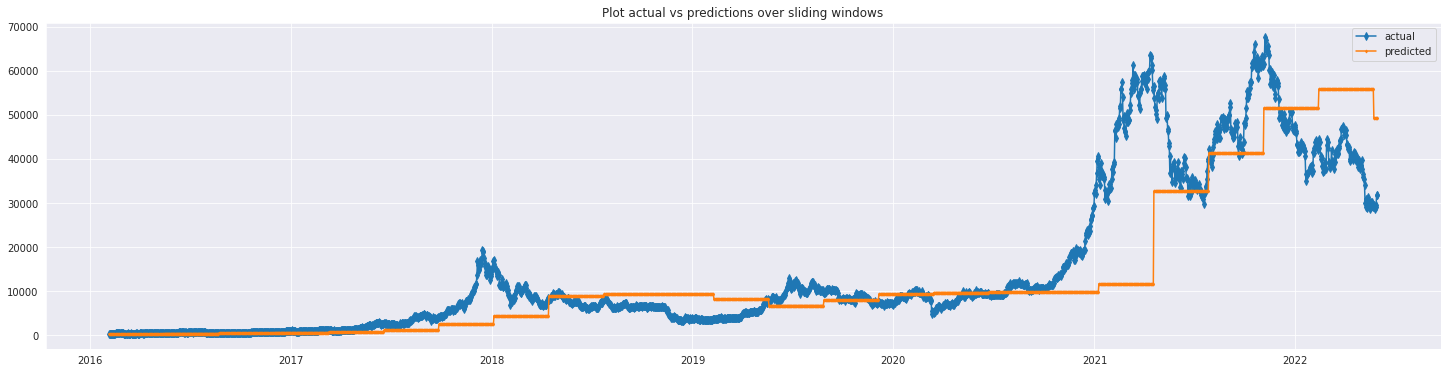

In [17]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

## Support Vector Machine Regressor

In [18]:
SVRegressor=SVR(kernel= 'linear', C= 1e+4)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  x_train_windows_scaled = scale_data1(x_train_windows,x_train_windows)
  x_test_windows_scaled = scale_data1(x_train_windows,x_test_windows)

  SVRegressor.fit(x_train_windows_scaled,np.ravel(y_train_windows))

  y_train_pred_SVM = SVRegressor.predict(x_train_windows_scaled)
  y_test_pred_SVM = SVRegressor.predict(x_test_windows_scaled)
  y_pred.extend(np.ravel(y_test_pred_SVM))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_SVM)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_SVM)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_SVM)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_SVM)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_SVM)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_SVM)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])


In [19]:
SVM_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [20]:
SVM_metrics.tail(5)

,start_date,end_date,mae_train,rmse_train,mape_train,mae_test,rmse_test,mape_test
19,2020/03/15,2021/07/27,593.667043,1089.246785,0.027575,1640.120835,2110.583907,0.040547
20,2020/06/23,2021/11/04,891.446596,1441.128886,0.030129,1559.840959,1991.134148,0.031060
21,2020/10/01,2022/02/12,1200.715929,1708.273935,0.030388,1175.958053,1686.110481,0.024228
22,2021/01/09,2022/05/23,1347.654282,1844.908147,0.028670,1065.374142,1412.195772,0.027205
23,2021/04/19,2022/05/30,1227.391069,1677.418857,0.027525,614.318610,928.809234,0.020540


In [21]:
pd.DataFrame(SVM_metrics.iloc[:,2:].mean())

,0
mae_train,333.082659
rmse_train,520.814524
mape_train,0.027116
mae_test,480.275646
rmse_test,659.295312
mape_test,0.029332


In [22]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

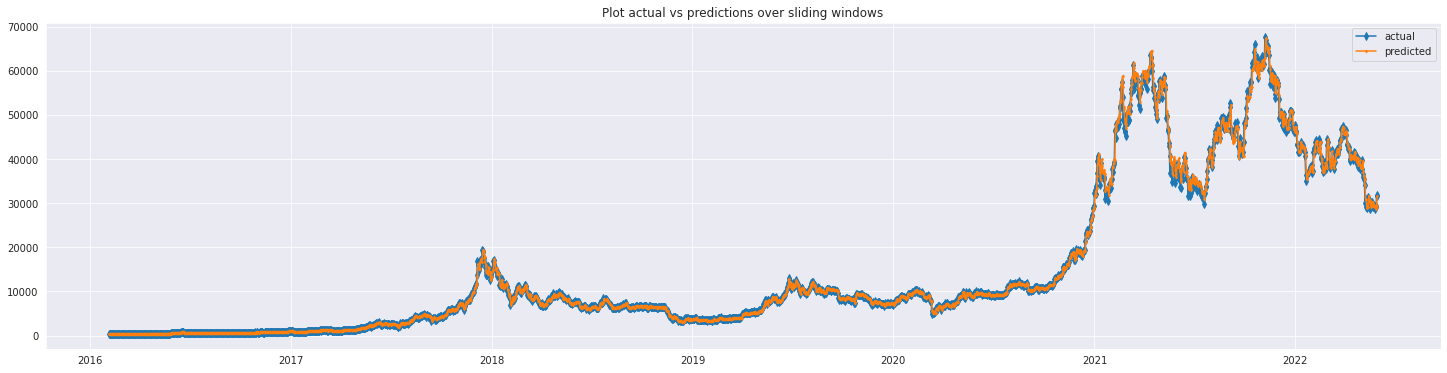

In [23]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

In [24]:
data_selected_final = data_selected_final_24_4.copy().iloc[-1095:,:]
train_split = int(len(data_selected_final)*80/100)
date = np.ravel(data_selected_final.iloc[:,:1])
X_train = data_selected_final.iloc[:,1:-1][:train_split]
Y_train= data_selected_final.iloc[:,-1:][:train_split]
X_test = data_selected_final.iloc[:,1:-1][train_split:]
Y_test = data_selected_final.iloc[:,-1:][train_split:]

X_train_scaled = scale_data1(X_train,X_train)
X_test_scaled = scale_data1(X_train,X_test)

SVRegressor.fit(X_train_scaled,np.ravel(Y_train))

Y_train_pred_SVM = SVRegressor.predict(X_train_scaled)
Y_test_pred_SVM = SVRegressor.predict(X_test_scaled)
Y_actual = np.concatenate((np.ravel(Y_train),np.ravel(Y_test)))
Y_pred = np.concatenate((np.ravel(Y_train_pred_SVM),np.ravel(Y_test_pred_SVM)))


In [25]:
df_predictions_final = pd.DataFrame({'Date':date,'Y_actual':Y_actual,'Y_pred':Y_pred})
df_predictions_final.index = df_predictions_final['Date']
df_predictions_final.drop(['Date'],axis=1,inplace=True)
df_predictions_final.index = pd.to_datetime(df_predictions_final.index)

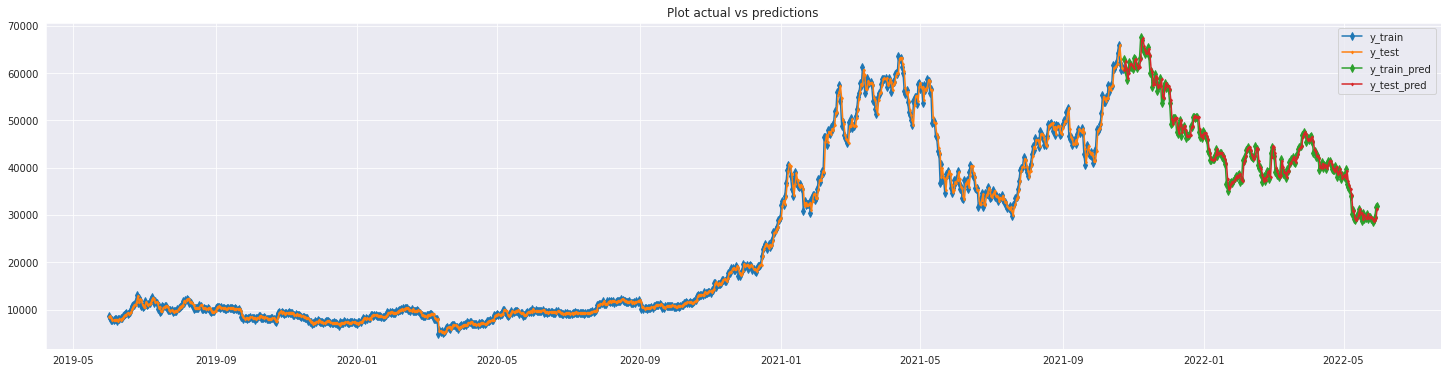

In [26]:
plt.figure(figsize=(25,6))
plt.plot(df_predictions_final['Y_actual'][:train_split],  label = "y_train",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][:train_split],  label = "y_test",marker='d',markersize=2)
plt.plot(df_predictions_final['Y_actual'][train_split:],  label = "y_train_pred",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][train_split:],  label = "y_test_pred",marker='d',markersize=2)
plt.title('Plot actual vs predictions')
plt.legend()
plt.show()

In [27]:
metrics_final('train',df_predictions_final['Y_actual'][:train_split],df_predictions_final['Y_pred'][:train_split])

MAE_train: 659.3510964240293
MAPE_train: 0.029531952588408374
RMSE_train: 1179.4795490888628


In [28]:
metrics_final('test',df_predictions_final['Y_actual'][train_split:],df_predictions_final['Y_pred'][train_split:])

MAE_test: 1114.705591826667
MAPE_test: 0.025124416602156585
RMSE_test: 1542.5059458752532


## Linear Regression with SGD optimizer

In [29]:
SGDreg = SGDRegressor(max_iter=1e+07,loss ='squared_epsilon_insensitive' ,tol=1e-3,learning_rate='adaptive',eta0 =0.01)

train_metric_MAE = []
train_metric_RMSE = []
train_metric_MAPE = []
test_metric_MAE = []
test_metric_RMSE = []
test_metric_MAPE = []
start_date = []
end_date = []
Date = []
y_actual = []
y_pred = []

for i in range(len(train_windows)):
  #train_window_II = outliers(train_windows[i],0.3)
  train_window_II = train_windows[i]
  test_window_II = test_windows[i]
  x_train_windows = train_window_II.iloc[:,1:-1]
  y_train_windows = train_window_II.iloc[:,-1:]
  x_test_windows = test_window_II.iloc[:,1:-1]
  y_test_windows = test_window_II.iloc[:,-1:]
  Date.extend(np.ravel(test_window_II['Date']))
  y_actual.extend(np.ravel(y_test_windows))

  x_train_windows_scaled = scale_data1(x_train_windows,x_train_windows)
  x_test_windows_scaled = scale_data1(x_train_windows,x_test_windows)
  
  SGDreg.fit(x_train_windows_scaled,np.ravel(y_train_windows))

  y_train_pred_SGDr = SGDreg.predict(x_train_windows_scaled)
  y_test_pred_SGDr = SGDreg.predict(x_test_windows_scaled)
  y_pred.extend(np.ravel(y_test_pred_SGDr))
  
  train_metric_MAE.append(MAE(np.ravel(y_train_windows),np.ravel(y_train_pred_SGDr)))
  train_metric_RMSE.append(RMSE(np.ravel(y_train_windows),np.ravel(y_train_pred_SGDr)))
  train_metric_MAPE.append(MAPE(np.ravel(y_train_windows),np.ravel(y_train_pred_SGDr)))

  test_metric_MAE.append(MAE(np.ravel(y_test_windows),np.ravel(y_test_pred_SGDr)))
  test_metric_RMSE.append(RMSE(np.ravel(y_test_windows),np.ravel(y_test_pred_SGDr)))
  test_metric_MAPE.append(MAPE(np.ravel(y_test_windows),np.ravel(y_test_pred_SGDr)))

  start_date.append(train_windows[i]['Date'][0])
  end_date.append(test_windows[i]['Date'][len(test_windows[i]['Date'])-1])

In [30]:
SGDr_metrics= pd.DataFrame({'start_date':start_date,'end_date':end_date,'mae_train':train_metric_MAE,
                              'rmse_train':train_metric_RMSE,
                              'mape_train':train_metric_MAPE,
                              'mae_test':test_metric_MAE,
                              'rmse_test':test_metric_RMSE,
                              'mape_test':test_metric_MAPE
                              })

In [31]:
SGDr_metrics.tail(5)

,start_date,end_date,mae_train,rmse_train,mape_train,mae_test,rmse_test,mape_test
19,2020/03/15,2021/07/27,614.631231,1082.986395,0.028549,2220.881719,2683.971862,0.054905
20,2020/06/23,2021/11/04,925.771809,1429.873549,0.031289,1664.227834,2070.454680,0.033139
21,2020/10/01,2022/02/12,1222.814072,1691.602897,0.030948,1256.927030,1790.957315,0.025896
22,2021/01/09,2022/05/23,1366.320264,1838.999132,0.029068,1065.705375,1417.013060,0.027213
23,2021/04/19,2022/05/30,1241.798320,1675.358813,0.027848,606.140843,898.413884,0.020267


In [32]:
pd.DataFrame(SGDr_metrics.iloc[:,2:].mean())

,0
mae_train,342.329816
rmse_train,518.010096
mape_train,0.028452
mae_test,550.601401
rmse_test,736.917490
mape_test,0.033210


In [33]:
df_predictions = pd.DataFrame({'Date':Date,'y_actual':y_actual,'y_pred':y_pred})
df_predictions.index = df_predictions['Date']
df_predictions.drop(['Date'],axis=1,inplace=True)
df_predictions.index = pd.to_datetime(df_predictions.index)

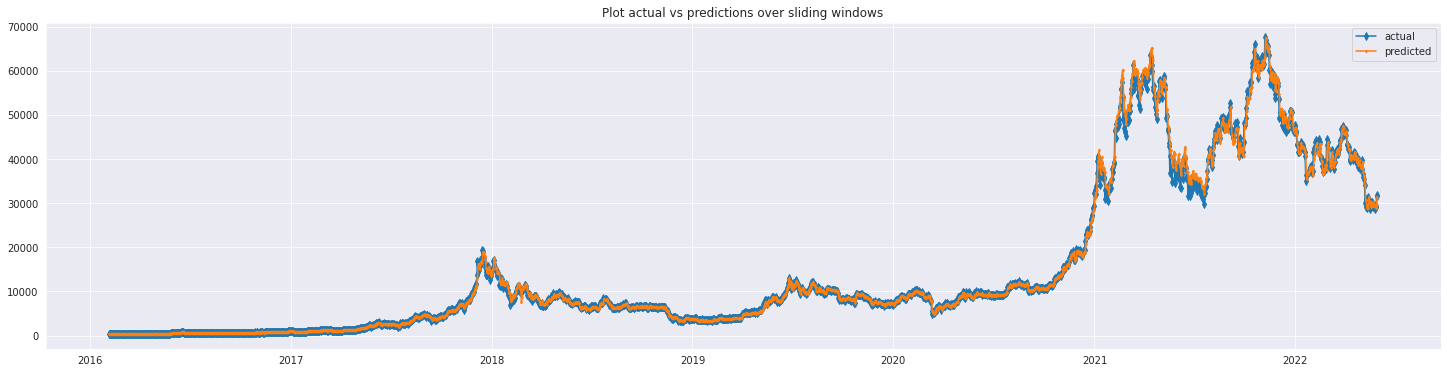

In [34]:
# plotting model performance on seen and unseen data
plt.figure(figsize=(25,6))
plt.plot(df_predictions['y_actual'],  label = "actual",marker='d',markersize=5)
plt.plot(df_predictions['y_pred'],  label = "predicted",marker='d',markersize=2)
plt.title('Plot actual vs predictions over sliding windows')
#plt.xlim(1600,)
plt.legend()
plt.show()

In [35]:
data_selected_final = data_selected_final_24_4.copy().iloc[-1095:,:]
train_split = int(len(data_selected_final)*80/100)
date = np.ravel(data_selected_final.iloc[:,:1])
X_train = data_selected_final.iloc[:,1:-1][:train_split]
Y_train= data_selected_final.iloc[:,-1:][:train_split]
X_test = data_selected_final.iloc[:,1:-1][train_split:]
Y_test = data_selected_final.iloc[:,-1:][train_split:]

X_train_scaled = scale_data1(X_train,X_train)
X_test_scaled = scale_data1(X_train,X_test)

SGDreg.fit(X_train_scaled,np.ravel(Y_train))

Y_train_pred_SGDr = SGDreg.predict(X_train_scaled)
Y_test_pred_SGDr = SGDreg.predict(X_test_scaled)
Y_actual = np.concatenate((np.ravel(Y_train),np.ravel(Y_test)))
Y_pred = np.concatenate((np.ravel(Y_train_pred_SGDr),np.ravel(Y_test_pred_SGDr)))


In [36]:
df_predictions_final = pd.DataFrame({'Date':date,'Y_actual':Y_actual,'Y_pred':Y_pred})
df_predictions_final.index = df_predictions_final['Date']
df_predictions_final.drop(['Date'],axis=1,inplace=True)
df_predictions_final.index = pd.to_datetime(df_predictions_final.index)

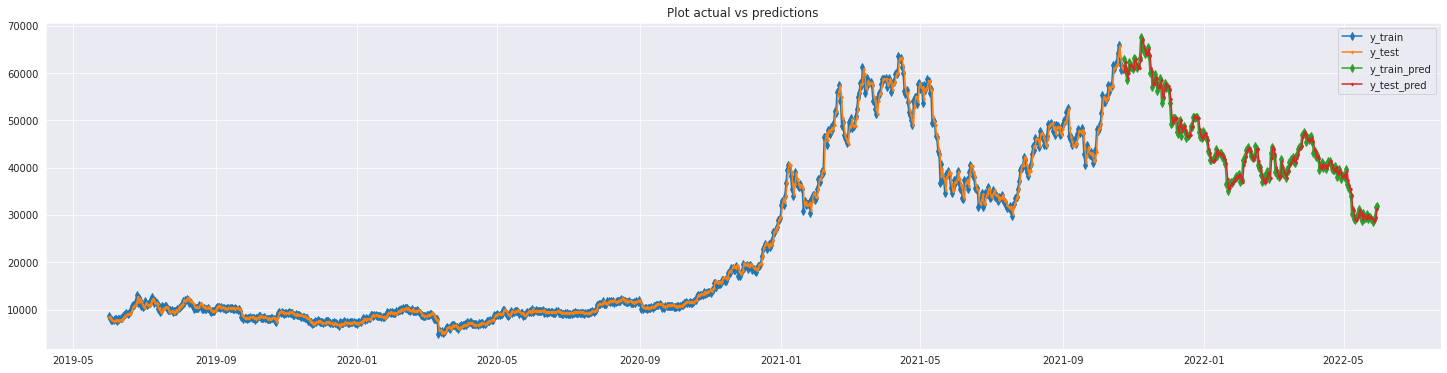

In [37]:
import datetime 
plt.figure(figsize=(25,6))
plt.plot(df_predictions_final['Y_actual'][:train_split],  label = "y_train",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][:train_split],  label = "y_test",marker='d',markersize=2)
plt.plot(df_predictions_final['Y_actual'][train_split:],  label = "y_train_pred",marker='d',markersize=5)
plt.plot(df_predictions_final['Y_pred'][train_split:],  label = "y_test_pred",marker='d',markersize=2)
plt.title('Plot actual vs predictions')
plt.legend()
plt.show()

In [38]:
metrics_final('train',df_predictions_final['Y_actual'][:train_split],df_predictions_final['Y_pred'][:train_split])

MAE_train: 676.710461060942
MAPE_train: 0.030309468446352
RMSE_train: 1177.0168768812196


In [39]:
metrics_final('test',df_predictions_final['Y_actual'][train_split:],df_predictions_final['Y_pred'][train_split:])

MAE_test: 1122.0252645701723
MAPE_test: 0.02528939514783511
RMSE_test: 1546.6597136434812
